[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/data_augmenation_segmentation.ipynb)

# **Data Augmentation Semantic Segmentation**

In this tutorial we will show we can quickly perform **data augmentation for semantic segmenation** using the `kornia.augmentation` API.

The API is under refactoring, *NOTICE* that this might be different in the near future.

## Install and get data

We install Kornia and some dependencies, and download a simple data sample

In [1]:
%%capture
!pip install kornia opencv-python matplotlib

In [3]:
%%capture
!!wget http://www.zemris.fer.hr/~ssegvic/multiclod/images/causevic16semseg3.png

In [4]:
# import the libraries
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

import torch
import torch.nn as nn
import kornia as K

## Define Augmentation pipeline

We define a class to define our augmentation API using an `nn.Module`

In [5]:
class MyAugmentation(nn.Module):
  def __init__(self):
    super(MyAugmentation, self).__init__()
    # we define and cache our operators as class members
    self.k1 = K.augmentation.ColorJitter(0.15, 0.25, 0.25, 0.25)
    self.k2 = K.augmentation.RandomAffine([-45., 45.], [0., 0.15], [0.5, 1.5], [0., 0.15])
  
  def forward(self, img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # 1. apply color only in image
    # 2. apply geometric tranform
    img_out = self.k2(self.k1(img))

    # 3. infer geometry params to mask
    # TODO: this will change in future so that no need to infer params
    mask_out = self.k2(mask, self.k2._params)

    return img_out, mask_out

Load the data and apply the transforms

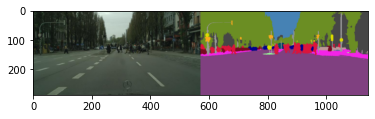

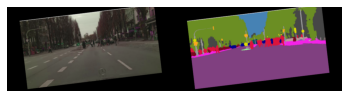

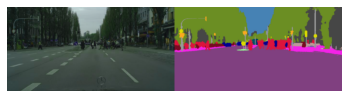

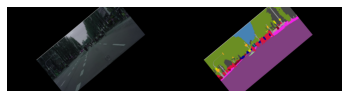

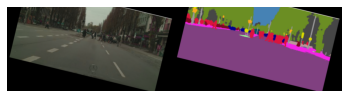

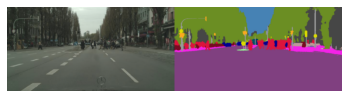

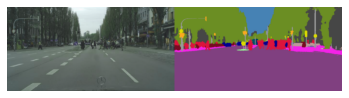

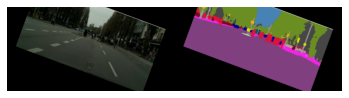

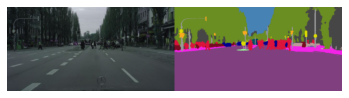

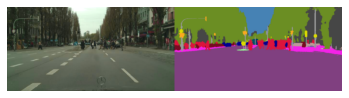

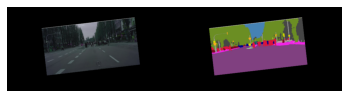

In [6]:
def load_data(data_path: str) -> torch.Tensor:
  data: np.ndarray = cv2.imread(data_path, cv2.IMREAD_COLOR)
  data_t: torch.Tensor = K.image_to_tensor(data, keepdim=False)
  data_t = K.bgr_to_rgb(data_t)
  data_t = K.normalize(data_t, 0., 255.)
  img, labels = data_t[..., :571], data_t[..., 572:]
  return img, labels

# load data (B, C, H, W)
img, labels = load_data("causevic16semseg3.png")

# create augmentation instance
aug = MyAugmentation()

# apply the augmenation pipelone to our batch of data
img_aug, labels_aug = aug(img, labels)

# visualize
img_out = torch.cat([img, labels], dim=-1)
plt.imshow(K.tensor_to_image(img_out))

# generate several samples
num_samples: int = 10

for img_id in range(num_samples):
  # generate data
  img_aug, labels_aug = aug(img, labels)
  img_out = torch.cat([img_aug, labels_aug], dim=-1)

  # save data
  plt.figure()
  plt.imshow(K.tensor_to_image(img_out))
  plt.axis('off')
  plt.savefig(f"img_{img_id}.png", bbox_inches='tight')